In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import cv2
import imutils
import pickle

In [5]:
from utils.utils import open_video, crop_margins, map_frames, get_game_margins, dist

In [6]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
# screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

In [ ]:
# check if all screens are present

fig, axs = plt.subplots(figsize=(16, 96))

for i, s in tqdm(enumerate(screen_to_frame.values())):
    plt.title(f"Screen {i}")
    plt.subplot(22, 2, i + 1)
    plt.imshow(s)

fig.tight_layout()

In [19]:
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [21]:
def data_coord2view_coord(p, resolution, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * resolution
    return dv

def kNN2DDens(xv, yv, resolution, neighbours, dim=2):
    """
    """
    # Create the tree
    tree = cKDTree(np.array([xv, yv]).T)
    # Find the closest nnmax-1 neighbors (first entry is the point itself)
    grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, dim)
    dists = tree.query(grid, neighbours)
    # Inverse of the sum of distances to each grid point.
    inv_sum_dists = 1. / dists[0].sum(1)

    # Reshape
    im = inv_sum_dists.reshape(resolution, resolution)
    return im

In [24]:
n = 100
xs = np.random.randn(n)
ys = np.random.randn(n)

resolution = 250

extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]
xv = data_coord2view_coord(xs, resolution, extent[0], extent[1])
yv = data_coord2view_coord(ys, resolution, extent[2], extent[3])

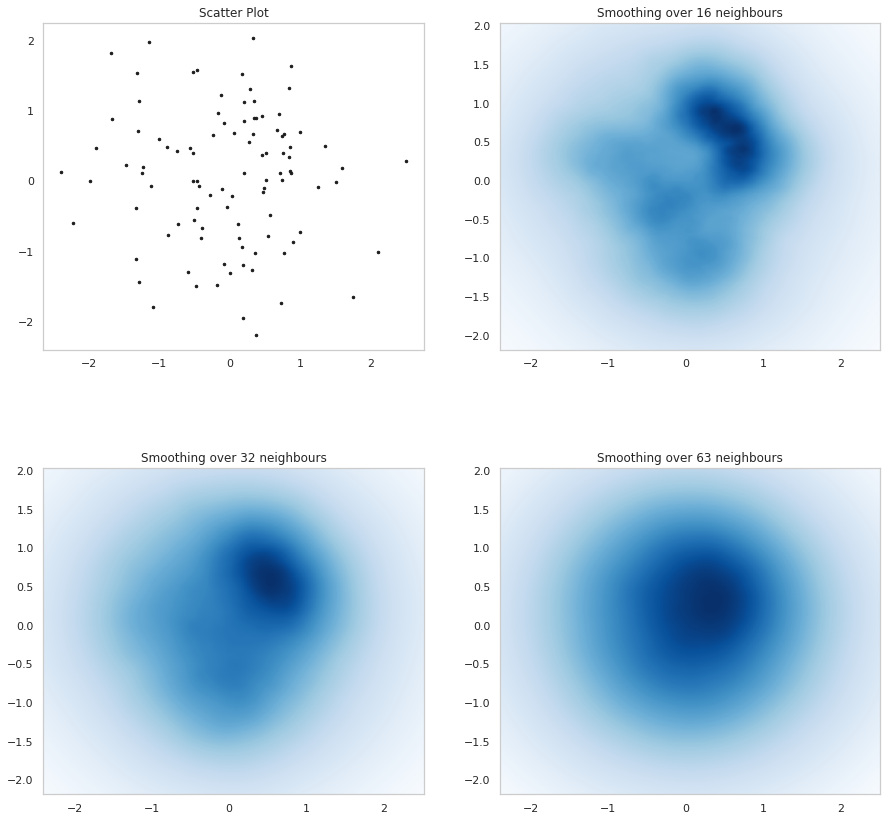

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for ax, neighbours in zip(axes.flatten(), [0, 16, 32, 63]):

    if neighbours == 0:
        ax.plot(xs, ys, 'k.', markersize=5)
        ax.set_aspect('equal')
        ax.set_title("Scatter Plot")
    else:

        im = kNN2DDens(xv, yv, resolution, neighbours)

        ax.imshow(im, origin='lower', extent=extent, cmap=cm.Blues)
        ax.set_title("Smoothing over %d neighbours" % neighbours)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

plt.savefig('new.png', dpi=150, bbox_inches='tight')

what am i going to present:

width 60 of every video

last screen corner case
detect not continuous video corner case

find global position of game on screen
* detect the black line on top
    
* heatmap:
    * array of coordinates
    * for each frame
    * screen = frame_to_screen(i) # offset?
    * background = screen_to_frame[screen]
    * detect king
    * screen_to_positions = {screen: [[x, y]]}
    * after:
    * for each screen
    * make a heatmap
    * https://github.com/TobiasRoeddiger/GazePointHeatMap/blob/master/gazeheatplot.py
    * https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set
    * rgba to make transparent
* statistical
    * screentime
    * number of falls (12-13 screens)
    * number of total falls
* corner cases
    

pipeline:
* map_screens.py and screen_to_frame.py for static files
* map_frames(filename, screen_to_frame)
* for each screen in screen to frames detect motion

https://www.sicara.ai/blog/en/object-detection-template-matching

https://debuggercafe.com/moving-object-detection-using-frame-differencing-with-opencv/

https://towardsdatascience.com/build-a-motion-heatmap-videousing-opencv-with-python-fd806e8a2340

https://github.com/kjw0612/awesome-deep-vision#imagenet-classification

-

https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/

In [7]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

In [8]:
screen_to_frames, frame_to_screen = map_frames('data/speedrun_side.mp4', screen_to_frame)

getting video start


  0%|          | 0/11277 [00:00<?, ?it/s]

video starts at frame 325
mapping screens


  0%|          | 0/10952 [00:00<?, ?it/s]

done mapping screens


In [9]:
cap = open_video('data/speedrun_side.mp4')
margin_left, margin_right = get_game_margins(cap)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [13]:
screen_to_positions = {}  # {screen: [[x, y]]}
positions = []

# some screens are badly initialized

# if go back, then have to initialize screen_positions differently
# if go back, then have to jump to next frame first
for screen, frames in tqdm(screen_to_frames.items()):
    if screen == 42:
        continue
    for (start, end) in frames:
        n = end - start
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        frames = []
        for i in range(n):
            ret, frame = cap.read()
            if ret == False:
                break

            frame = crop_margins(frame, margin_left, margin_right)
            frame = imutils.resize(frame, width=60)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        avg_frame = np.mean(frames, axis=0).astype(np.uint8)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        if len(positions) != 0:
            x, _ = positions[-1]
            screen_positions = [(x, frame.shape[0])]
        else:
            screen_positions = [(30, 40)]

        for i in range(n):
            ret, frame = cap.read()
            if ret == False:
                break

            frame = crop_margins(frame, margin_left, margin_right)
            frame = imutils.resize(frame, width=60)
            orig_frame = frame.copy()

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_diff = cv2.absdiff(avg_frame, frame)

            # exponential smoothing
            # TODO: if needed
            # avg_frame = (0.3 * frame + 0.7 * avg_frame).astype(np.uint8)

            ret, thres = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)
            dilate_frame = cv2.dilate(thres, None, iterations=2)

            contours, hierarchy = cv2.findContours(dilate_frame,
                                                   cv2.RETR_EXTERNAL,
                                                   cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(orig_frame, (x, y), (x + w, y + h), (0, 0, 255),
                              1)

            if len(contours) == 0:
                screen_positions.append(screen_positions[-1])
            elif len(contours) == 1:
                (x, y, w, h) = cv2.boundingRect(contours[0])
                if dist(screen_positions[-1], (x + w // 2, y + h // 2)) > 200:
                    #print("more than 50")
                    # detected another object
                    screen_positions.append(screen_positions[-1])
                else:
                    # print("her")
                    screen_positions.append((x + w // 2, y + h // 2))
            else:
                distances = []
                for contour in contours:
                    (x, y, w, h) = cv2.boundingRect(contour)
                    distances.append(
                        dist(screen_positions[-1], (x + w // 2, y + h // 2)))
                pidx = np.argmin(distances)
                (x, y, w, h) = cv2.boundingRect(contours[pidx])
                screen_positions.append((x + w // 2, y + h // 2))

            x, y = screen_positions[-1]

        positions = positions + screen_positions

  0%|          | 0/43 [00:00<?, ?it/s]

In [138]:
cap.release()

44x60 frame

y x

positions are
x y

In [14]:
positions

[(30, 40),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 37),
 (29, 36),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),

In [ ]:
king = cv2.imread('data/king.webp')

In [ ]:
plt.imshow(king)

In [ ]:
king.shape